In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random

seed = 0
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
%reload_ext autoreload
%autoreload 2

from src.constants import csv_file, directory, INPUT_SHAPE, YEAR, ext

from src.utils import (
    get_dataloader,
    split_val,
    plot_confusion_matrix, 
    calculate_confusion_binary, 
    calculate_confusion_matrix,
)

from src.model import Model_Retinopathy
from src.server_scaffold import Server_Scaffold
from src.server_fedavg import Server_FedAVG

from src.constants import EPOCHS, BATCH_SIZE, LEARNING_RATE, UPDATES
from src.constants import K_CLIENTS, C, rounds, clients
from src.constants import optimizer_fn, plot_title, just_converge

print(plot_title)

Regular CNN - 20 clients non-IID


In [4]:
# DATA STUFF
df = pd.read_csv(csv_file)
df, test_df = split_val(df, 0.15)
df, val_df = split_val(df, 0.118)

print(len(df), len(val_df), len(test_df))

_, val_loader = get_dataloader(val_df, ext, directory, BATCH_SIZE)
_, test_loader = get_dataloader(test_df, ext, directory, BATCH_SIZE)

2745 367 550


In [5]:
server_fedavg = Server_FedAVG(K_CLIENTS, optimizer_fn, df, val_loader)

In [6]:
server_fedavg.train_loop(rounds, EPOCHS)
file_path = f"{plot_title}/FedAvg_results.txt"
with open(file_path, "a") as f:
    print("TESTING: ", server_fedavg.validate(test_loader), file=f)
    if not just_converge:
        print("\n", file=f)
        for i, client in enumerate(server_fedavg.clients_ind):
            val = client.validate(test_loader)
            print(f"Client test {i}: {val}", file=f)

GLOBAL: {'loss': 1.5899, 'accuracy': 0.4932, 'f1': 0.0, 'accuracy_binary': 0.4932, 'recall': 0.0, 'precision': 0.0}
Round 0
--------------------------------------------------
Client 0:
Epoch 0: {'loss': 1.398, 'accuracy': 0.2725, 'f1': 0.6727, 'accuracy_binary': 0.5068, 'recall': 1.0, 'precision': 0.5068}
Epoch 1: {'loss': 1.4445, 'accuracy': 0.2725, 'f1': 0.6727, 'accuracy_binary': 0.5068, 'recall': 1.0, 'precision': 0.5068}
Epoch 2: {'loss': 1.5374, 'accuracy': 0.4932, 'f1': 0.0, 'accuracy_binary': 0.4932, 'recall': 0.0, 'precision': 0.0}
Epoch 3: {'loss': 1.6525, 'accuracy': 0.4932, 'f1': 0.0, 'accuracy_binary': 0.4932, 'recall': 0.0, 'precision': 0.0}
Epoch 4: {'loss': 1.69, 'accuracy': 0.4932, 'f1': 0.0, 'accuracy_binary': 0.4932, 'recall': 0.0, 'precision': 0.0}
Client 1:
Epoch 0: {'loss': 1.3874, 'accuracy': 0.2725, 'f1': 0.6727, 'accuracy_binary': 0.5068, 'recall': 1.0, 'precision': 0.5068}
Epoch 1: {'loss': 1.3931, 'accuracy': 0.2725, 'f1': 0.6727, 'accuracy_binary': 0.5068, '

KeyboardInterrupt: 

In [ ]:
del server_fedavg
torch.cuda.empty_cache()
gpu_memory = torch.cuda.memory_allocated()
print(gpu_memory / (1024**2), "MB")
server_scaffold = Server_Scaffold(K_CLIENTS, optimizer_fn, df, val_loader)
print((torch.cuda.memory_allocated()) / (1024**2), "MB")

1813.28759765625 MB
3610.3251953125 MB


In [ ]:
server_scaffold.train_loop(rounds, EPOCHS)
file_path = f"{plot_title}/SCAFFOLD_results.txt"
with open(file_path, "a") as f:
    print("TESTING: ", server_scaffold.validate(test_loader), file=f)
    if not just_converge:
        print("\n", file=f)
        for i, client in enumerate(server_scaffold.clients_ind):
            val = client.validate(test_loader)
            print(f"Client {i} tested")
            print(f"Client test {i}: {val}", file=f)

GLOBAL: {'loss': 1.6496, 'accuracy': 0.1771, 'f1': 0.6727, 'accuracy_binary': 0.5068, 'recall': 1.0, 'precision': 0.5068}
3610.3251953125 MB
Round 0
--------------------------------------------------
3610.3251953125 MB
Client 0:
3610.3251953125 MB
Epoch 0: {'loss': 1.529, 'accuracy': 0.2371, 'f1': 0.6593, 'accuracy_binary': 0.4932, 'recall': 0.9677, 'precision': 0.5}
3655.37744140625 MB
Epoch 1: {'loss': 1.4324, 'accuracy': 0.3215, 'f1': 0.6226, 'accuracy_binary': 0.5177, 'recall': 0.7849, 'precision': 0.5159}
3655.59228515625 MB
Epoch 2: {'loss': 1.3678, 'accuracy': 0.3896, 'f1': 0.642, 'accuracy_binary': 0.5777, 'recall': 0.7473, 'precision': 0.5628}
3656.87744140625 MB
Epoch 3: {'loss': 1.323, 'accuracy': 0.4768, 'f1': 0.7146, 'accuracy_binary': 0.6757, 'recall': 0.8011, 'precision': 0.645}
3656.30322265625 MB
Epoch 4: {'loss': 1.2927, 'accuracy': 0.5422, 'f1': 0.7526, 'accuracy_binary': 0.7384, 'recall': 0.7849, 'precision': 0.7228}
3611.8134765625 MB
Client 1:
3611.8134765625 MB
E

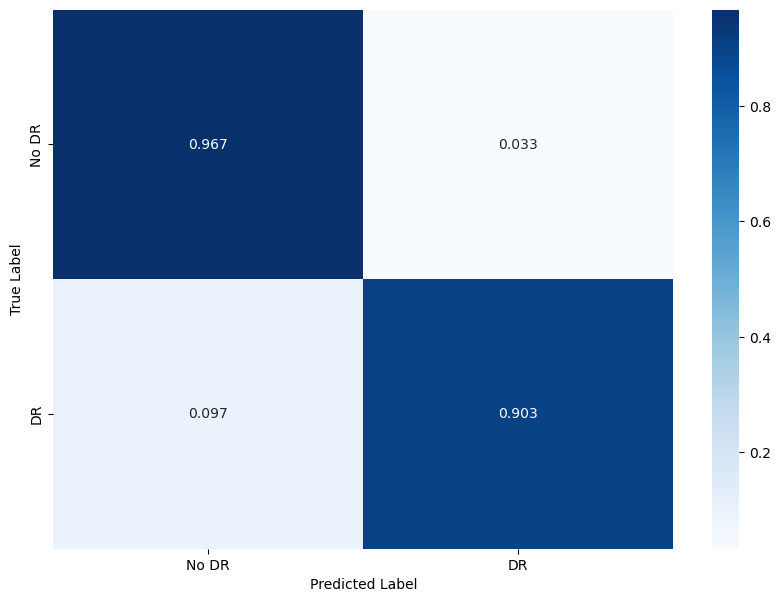

In [ ]:
cmb = calculate_confusion_binary(server_scaffold.model, val_loader)
plot_confusion_matrix(cmb, ["No DR", "DR"])

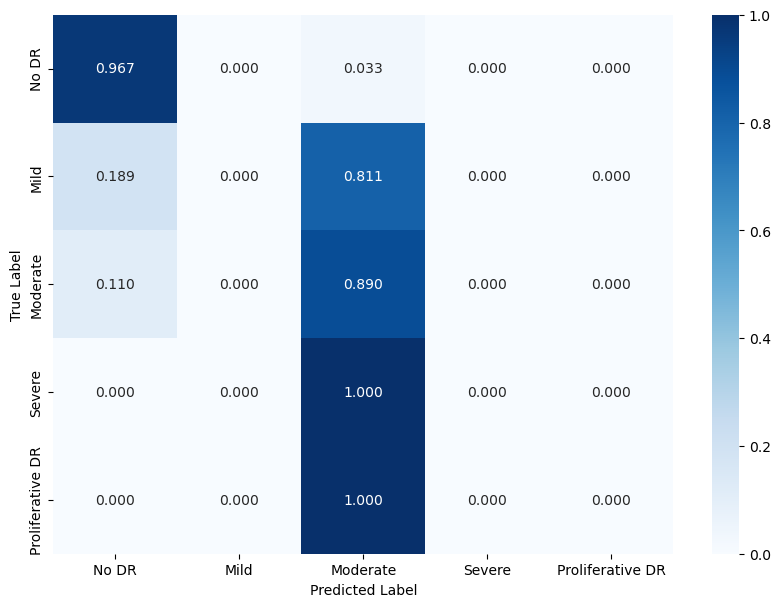

In [ ]:
cm = calculate_confusion_matrix(server_scaffold.model, val_loader)
plot_confusion_matrix(cm, ["No DR", "Mild", "Moderate", "Severe", "Proliferative DR"])